# Measuring accuracy of k-fold models

## Aims

* Measure a range of accuracy scores (e.g. accuracy, sensitivity, specificity, F1, etc).
* Plot Receiver Operator Characteristic Curve and measure AUC.
* Identify cross-over point of sensitivity and specificity.
* Save individual patient predictions.
* Compare predicted and observed thrombolysis use at each hospital.
* Examine learning curves
* Check model calibration.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler

## Set modifications to apply

In [2]:
use_minority_oversampling = True

# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
model_type = 'xgb_individual'

## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [4]:
data_loc = './data/kfold_5fold/'

In [5]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(data_loc + 'train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(data_loc + 'test_{0}.csv'.format(i)))

## Functions 

### Calculate accuracy measures

In [6]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

### Line intersect

Used to find point of sensitivity-specificity curve where sensitivity = specificity.

In [7]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

## Fit model (k-fold)

In [8]:
# Set up list to store models
models = []
observed = []
predicted = []
combined_test_set = []
predicted_proba = []
test_hospitals = []

# Loop through k folds
for k_fold in range(5):
    
    models_run = dict()
    
    # Set up lists for observed and predicted
    observed_run = []
    predicted_run = []
    predicted_proba_run = []
    test_hospitals_run = []
    
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]
    
    # Get list of hospitals
    hospitals = list(set(train['StrokeTeam']))
    hospitals.sort()
    
    # Get X and y
    X_train = train.drop('S2Thrombolysis', axis=1)
    X_test = test.drop('S2Thrombolysis', axis=1)
    y_train = train['S2Thrombolysis']
    y_test = test['S2Thrombolysis']
    
    # Loop through hospitals
    for hospital in hospitals:
        
        # Get hospital data
        mask = train['StrokeTeam'] == hospital
        X_train_hosp = train[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
        y_train = train[mask]['S2Thrombolysis']

        mask = test['StrokeTeam'] == hospital
        combined_test_set.append(test[mask])
        X_test_hosp = test[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
        y_test = test[mask]['S2Thrombolysis']
        
        # Use oversampling if required
        if use_minority_oversampling:
            oversample = RandomOverSampler(sampling_strategy='minority')
            X_train_hosp, y_train = oversample.fit_resample(
                X_train_hosp, y_train)

        # Define model
        model = XGBClassifier(verbosity=0, seed=42)

        # Fit model
        model.fit(X_train_hosp, y_train)

        # Save to dictionary
        models_run[hospital] = model

        # Get predicted probabilities and class
        y_probs = model.predict_proba(X_test_hosp)[:,1]
        y_pred = y_probs > 0.5

        # Store results
        observed_run.extend(y_test.values)
        predicted_run.extend(y_pred * 1)
        predicted_proba_run.extend(y_probs)
        test_hospitals_run.extend([hospital for i in range(len(y_pred))])

     # Show accuracy
    accuracy = np.mean(np.array(observed_run) == np.array(predicted_run))
    print (f'Accuracy: {accuracy:0.3f}')
    
    # Strore run data
    models.append(models_run)
    observed.append(observed_run)
    predicted.append(predicted_run)   
    predicted_proba.append(predicted_proba_run)
    test_hospitals.append(test_hospitals_run)

Accuracy: 0.829
Accuracy: 0.832
Accuracy: 0.829
Accuracy: 0.835
Accuracy: 0.830


## Results 

### Accuracy measures 

In [9]:
# Set up list for results
k_fold_results = []

# Loop through k fold predictions and get accuracy measures
for i in range(5):
    results = calculate_accuracy(observed[i], predicted[i])
    k_fold_results.append(results)
    
# Put results in DataFrame
accuracy_results = pd.DataFrame(k_fold_results).T

In [10]:
accuracy_results

,0,1,2,3,4
observed_positive_rate,0.295963,0.295737,0.295867,0.295529,0.295472
observed_negative_rate,0.704037,0.704263,0.704133,0.704471,0.704528
predicted_positive_rate,0.297933,0.297427,0.298063,0.300259,0.299583
predicted_negative_rate,0.702067,0.702573,0.701937,0.699741,0.700417
accuracy,0.828538,0.831747,0.828753,0.834891,0.829767
precision,0.708940,0.714313,0.709050,0.717179,0.709023
recall,0.713661,0.718393,0.714313,0.728659,0.718887
f1,0.711292,0.716347,0.711672,0.722873,0.713921
sensitivity,0.713661,0.718393,0.714313,0.728659,0.718887
specificity,0.876830,0.879348,0.876839,0.879456,0.876269


In [11]:
accuracy_results.T.describe()

,observed_positive_rate,observed_negative_rate,predicted_positive_rate,predicted_negative_rate,accuracy,precision,recall,f1,sensitivity,specificity,positive_likelihood,negative_likelihood,false_positive_rate,false_negative_rate,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.295714,0.704286,0.298653,0.701347,0.830739,0.711701,0.718782,0.715221,0.718782,0.877748,5.880605,0.320392,0.122252,0.281218,0.718782,0.877748,0.711701,0.881430
std,0.000211,0.000211,0.001206,0.001206,0.002645,0.003830,0.005998,0.004732,0.005998,0.001528,0.113307,0.007216,0.001528,0.005998,0.005998,0.001528,0.003830,0.002437
min,0.295472,0.704037,0.297427,0.699741,0.828538,0.708940,0.713661,0.711292,0.713661,0.876269,5.794090,0.308533,0.120544,0.271341,0.713661,0.876269,0.708940,0.879291
25%,0.295529,0.704133,0.297933,0.700417,0.828753,0.709023,0.714313,0.711672,0.714313,0.876830,5.799850,0.320245,0.120652,0.281113,0.714313,0.876830,0.709023,0.879583
50%,0.295737,0.704263,0.298063,0.701937,0.829767,0.709050,0.718393,0.713921,0.718393,0.876839,5.810074,0.320807,0.123161,0.281607,0.718393,0.876839,0.709050,0.881412
75%,0.295867,0.704471,0.299583,0.702067,0.831747,0.714313,0.718887,0.716347,0.718887,0.879348,5.954235,0.325815,0.123170,0.285687,0.718887,0.879348,0.714313,0.881462
max,0.295963,0.704528,0.300259,0.702573,0.834891,0.717179,0.728659,0.722873,0.728659,0.879456,6.044773,0.326562,0.123731,0.286339,0.728659,0.879456,0.717179,0.885402


### Receiver Operator Characteristic and Sensitivity-Specificity Curves

Receiver Operator Characteristic Curve:

In [12]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(5):
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    roc_auc = auc(fpr, tpr)
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')


Mean AUC: 0.8924
SD AUC: 0.0027


Sensitivity-specificity curve:

In [13]:
k_fold_sensitivity = []
k_fold_specificity = []


for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = observed[i]
    proba = predicted_proba[i]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

Combined plot:

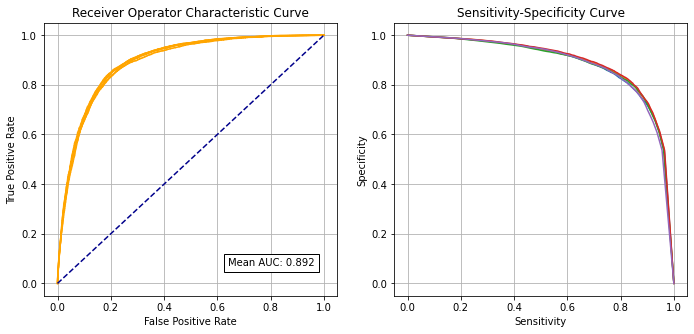

In [14]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig(f'./output/{model_type}_roc_sens_spec.jpg', dpi=300)

plt.show()

### Identify cross-over of sensitivity and specificity

In [15]:
intersections = []
for i in range(5):
    sens = np.array(k_fold_sensitivity[i])
    spec = np.array(k_fold_specificity[i])
    df = pd.DataFrame()
    df['sensitivity'] = sens
    df['specificity'] = spec
    df['spec greater sens'] = spec > sens

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    intersections.append(get_intersect(a1, a2, b1, b2)[0])

mean_intersection = np.mean(intersections)
sd_intersection = np.std(intersections)
print (f'\nMean intersection: {mean_intersection:0.4f}')
print (f'SD intersection: {sd_intersection:0.4f}')


Mean intersection: 0.8195
SD intersection: 0.0037


### Collate and save results 

In [16]:
hospital_results = []
kfold_result = []
observed_results = []
prob_results = []
predicted_results = []

for i in range(5):
    hospital_results.extend(list(test_hospitals[i]))
    kfold_result.extend(list(np.repeat(i, len(test_data[i]))))
    observed_results.extend(list(observed[i]))
    prob_results.extend(list(predicted_proba[i]))
    predicted_results.extend(list(predicted[i]))    
    
model_predictions = pd.DataFrame()
model_predictions['hospital'] = hospital_results
model_predictions['observed'] = np.array(observed_results) * 1.0
model_predictions['prob'] = prob_results
model_predictions['predicted'] = predicted_results
model_predictions['k_fold'] = kfold_result
model_predictions['correct'] = \
    model_predictions['observed'] == model_predictions['predicted']

# Save
filename = f'./predictions/{model_type}_predictions.csv'
model_predictions.to_csv(filename, index=False)

# Save combined test set
combined_test_set = pd.concat(combined_test_set, axis=0)
combined_test_set.reset_index(inplace=True); del combined_test_set['index']
combined_test_set.to_csv(f'./predictions/{model_type}_combined_test_set.csv')

## Compare predicted and actual thrombolysis rates

In [17]:
mean_results_by_hosp  = model_predictions.groupby('hospital').mean()

Get r-square of predicted thrombolysis rate.

In [18]:
x_comparision = np.array(mean_results_by_hosp['observed']).reshape(-1, 1)
y_comparision = np.array(mean_results_by_hosp['predicted']).reshape(-1, 1)

slr = LinearRegression()
slr.fit(x_comparision, y_comparision)
y_pred = slr.predict(x_comparision)
r_square = metrics.r2_score(y_comparision, y_pred)

print(f'R squared {r_square:0.3f}')

R squared 0.972


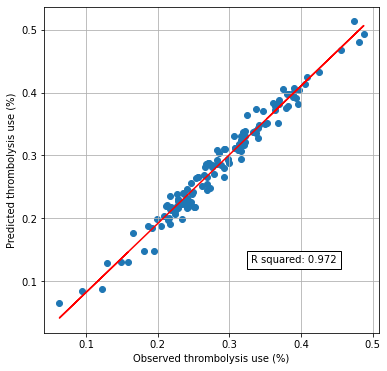

In [19]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x_comparision,
            y_comparision)

plt.plot (x_comparision, slr.predict(x_comparision), color = 'red')
text = f'R squared: {r_square:.3f}'
ax1.text(0.33,0.13, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Observed thrombolysis use (%)')
ax1.set_ylabel('Predicted thrombolysis use (%)')
plt.grid()
plt.savefig(f'output/{model_type}_observed_predicted_rates.jpg', dpi=300)
plt.show()

## Calibration and assessment of accuracy when model has high confidence

In [20]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for i in range(5):
    
    # Get observed class and predicted probability
    obs = observed[i]
    prob = np.array(predicted_proba[i])
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(prob, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = prob
    reliability['observed'] = obs
    classification = 1 * (prob > 0.5 )
    reliability['correct'] = obs == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = i

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

In [21]:
reliability_summary

,confidence,fraction_positive,fraction_correct,fraction_results
bin,,,,
0.1,0.013588,0.064800,0.935200,0.572856
0.2,0.144530,0.270505,0.729495,0.049475
0.3,0.247885,0.370462,0.629538,0.032019
0.4,0.348301,0.424390,0.575610,0.024417
0.5,0.450245,0.462008,0.537992,0.022581
0.6,0.549927,0.509242,0.509242,0.022784
0.7,0.651386,0.529759,0.529759,0.023606
0.8,0.751871,0.592474,0.592474,0.030656
0.9,0.854500,0.652994,0.652994,0.044824


Plot results:

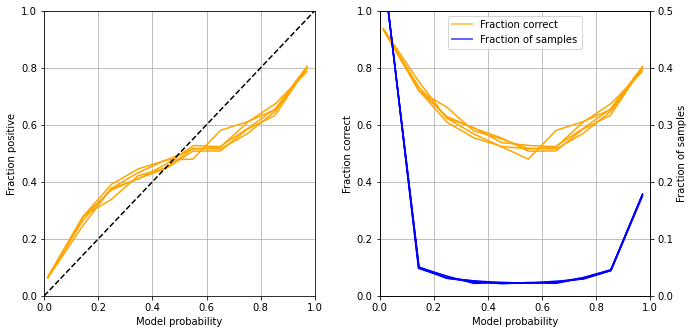

In [22]:
fig = plt.figure(figsize=(10,5))


# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

ax1.grid()
ax2.grid()

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)

plt.savefig(f'./output/{model_type}_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [23]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

For samples with at least 80% confidence:
Proportion of all samples: 0.844
Accuracy: 0.779


## Check for predicted thrombolysis in test set 

In [24]:
mask = combined_test_set['S2StrokeType_Infarction'] == 0
haemorrhagic_test = model_predictions['predicted'][mask]

In [25]:
count = len(haemorrhagic_test)
pos = haemorrhagic_test.sum()
print (f'{pos:.0f} predicted thrombolysis out of {count} haemorrhagic strokes')

77 predicted thrombolysis out of 13243 haemorrhagic strokes
